In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

def get_cor(d,y):
    regs=[]
    x=np.array(d)
    for i in range(len(x[0])):
        regs.append(stats.linregress(y,x[:,i]))
    rna=pd.DataFrame(np.array(regs)[:,2:4],index=d.columns,columns=['cor','p']).sort_values('cor',ascending=False)
    return rna

data='../data/'

rna_all=[]

In [8]:
%%time
clock_=data+'input/41467_2015_BFncomms9570_MOESM436_ESM.xlsx'
clock=pd.read_excel(clock_,skiprows=2,nrows=1497)
clock.index=clock['NEW-Gene-ID']
clock=clock[['RANK','META:Direction']]
clock=clock.rename(index={'GPR56':'ADGRG1'})
down=clock[clock['META:Direction']=='-']
up=clock[clock['META:Direction']=='+']

CPU times: user 662 ms, sys: 48 ms, total: 710 ms
Wall time: 809 ms


In [10]:
gen=pd.read_csv(data+'clean/genes.csv',index_col=0)
dic=gen.to_dict()['gen']
len(dic)

18937

In [18]:
cohort_dic={'mesa1':'MESA1','mesa2':'MESA2','ppmi':'PPMI','gc6':'GC6','dutch':'500FG','jena':'JenAge'}

In [ ]:
rna_all

In [19]:
%%time
rna_all=[]
for cohort in cohort_dic.keys():
    df=pd.read_pickle(data+'clean/cohorts/rna/'+cohort+'.pkl').T.drop(['sex'],axis=1)
    df=df.rename(columns=dic)
    dfm=np.log2(df.drop('age',axis=1)+1)
    dfm=(dfm.T-dfm.median(1)).T
    rna=get_cor(dfm,df['age'])
    rna['cohort']=cohort_dic[cohort]
    rna_all.append(rna)

CPU times: user 13.4 s, sys: 2.1 s, total: 15.5 s
Wall time: 16.2 s


In [33]:
pl=pd.concat(rna_all)
pl.loc[pl.index.isin(down.head(10).index),'top10']='down'
pl.loc[pl.index.isin(up.head(10).index),'top10']='up'
top=pl[pl['top10'].isin(['up','down'])][['cor','cohort','top10']]
top['gene']=top.index
top.shape

(114, 4)

In [43]:
cohort='gc6'
df=pd.read_pickle(data+'clean/cohorts/rna/'+cohort+'.pkl').T.drop(['sex'],axis=1)

/tmp/ipykernel_276350/1112701167.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size = 9);


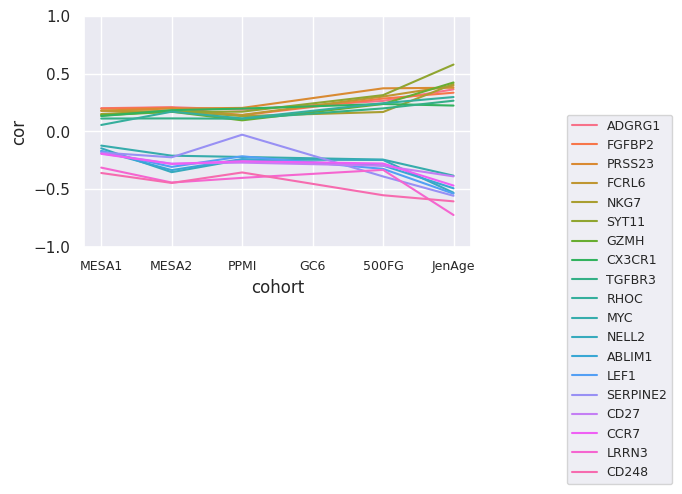

In [22]:
sns.set(rc={'figure.figsize':(5,3)})
ax=sns.lineplot(data=top.reset_index(),x='cohort',y='cor',hue='gene',sort=False);
ax.set(ylim=[-1,1])
ax.set_xticklabels(ax.get_xticklabels(), size = 9);
plt.legend(bbox_to_anchor=(1.23, .6),fontsize=9);

In [23]:
pl.loc[pl.index.isin(up.index),'proposed']='up'
pl.loc[pl.index.isin(down.index),'proposed']='down'
pl.to_csv(data+'result/rna_cor.csv')
pl.shape

(104282, 5)

In [ ]:
pl['cohort'].value_counts()

cohort
PPMI      18850
MESA1     18831
MESA2     18831
500FG     17415
JenAge    16845
GC6       13510
Name: count, dtype: int64

CPU times: user 239 ms, sys: 6.66 ms, total: 246 ms
Wall time: 244 ms


Text(0.5, 1.0, 'DNAm gain')

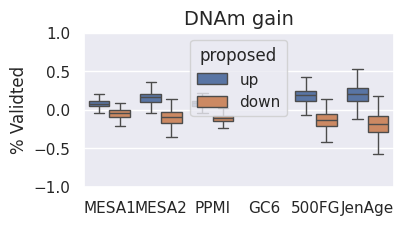

In [30]:
%%time
pl=pl[pl['proposed']!='na']
sns.set(rc={'figure.figsize':(4,2)})
order=['MESA1','MESA2','PPMI','GC6','500FG','JenAge']
ax=sns.boxplot(data=pl.reset_index(),x='cohort',y='cor',hue='proposed',showfliers=False,order=order)
ax.set(ylim=[-1,1],xlabel='',ylabel='% Validted')
plt.title('DNAm gain',size=14)

/tmp/ipykernel_219763/1771728313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl['valid']=False


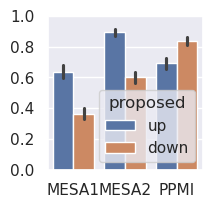

In [36]:
pl['valid']=False
pl.loc[(pl['proposed']=='up')&(pl['cor']>0)&(pl['p']<.05),'valid']=True
pl.loc[(pl['proposed']=='down')&(pl['cor']<0)&(pl['p']<.05),'valid']=True
sns.set(rc={'figure.figsize':(2,2)})
ax=sns.barplot(data=pl.reset_index(),x='cohort',y='valid',hue='proposed',order=['MESA1','MESA2','PPMI']);
ax.set(ylim=[0,1],xlabel='',ylabel='');

In [37]:
pl[['cohort','cor','top10','proposed','valid']].to_csv(data+'result/fig1_bd.csv')